In [ ]:
"""
File Name: main.ipynb
Author: Eli Claggett
Date: Apr 2023

Description:
    In-class project implementing a speech recognition model with attention

"""

In [ ]:
# Imports
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.distributions.categorical import Categorical
from torch.utils.data import Dataset, DataLoader
from torchnlp.nn import LockedDropout
from matplotlib import pyplot as plt
import torchaudio.transforms as tat
from torch.autograd import Variable
import torch.nn.functional as F
from tqdm.notebook import tqdm
import seaborn as sns
import torchsummaryX
import Levenshtein
import numpy as np
import wandb
import torch
import time 
import os

In [3]:
# Configuration
config = {
  'batch_size': 64,
  'lr':1e-3,
  'epochs': 150,
}

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", DEVICE)

In [8]:
# Load a toy dataset for phonetic transcription with attention

X_train = np.load("data/toy/f0176_mfccs_train_new.npy")
X_valid = np.load("data/toy/f0176_mfccs_dev_new.npy")
Y_train = np.load("data/toy/f0176_hw3p2_train.npy")
Y_valid = np.load("data/toy/f0176_hw3p2_dev.npy")

VOCAB_MAP_TOY           = dict(zip(np.unique(Y_valid), range(len(np.unique(Y_valid))))) 
VOCAB_MAP_TOY["[PAD]"]  = len(VOCAB_MAP_TOY)
VOCAB_TOY               = list(VOCAB_MAP_TOY.keys())

SOS_TOKEN_TOY = VOCAB_MAP_TOY["[SOS]"]
EOS_TOKEN_TOY = VOCAB_MAP_TOY["[EOS]"]
PAD_TOKEN_TOY = VOCAB_MAP_TOY["[PAD]"]

Y_train = [np.array([VOCAB_MAP_TOY[p] for p in seq]) for seq in Y_train]
Y_valid = [np.array([VOCAB_MAP_TOY[p] for p in seq]) for seq in Y_valid]

In [9]:
# Create the dataset
class ToyDataset(torch.utils.data.Dataset):

    def __init__(self, partition):

        if partition == "train":
            self.mfccs = X_train
            self.transcripts = Y_train

        elif partition == "valid":
            self.mfccs = X_valid
            self.transcripts = Y_valid

        assert len(self.mfccs) == len(self.transcripts)

        self.length = len(self.mfccs)

    def __len__(self):

        return self.length

    def __getitem__(self, i):

        x = torch.tensor(self.mfccs[i])
        y = torch.tensor(self.transcripts[i])

        return x, y

    def collate_fn(self, batch):

        x_batch, y_batch = list(zip(*batch))

        x_lens      = [x.shape[0] for x in x_batch] 
        y_lens      = [y.shape[0] for y in y_batch] 

        x_batch_pad = torch.nn.utils.rnn.pad_sequence(x_batch, batch_first=True, padding_value= EOS_TOKEN_TOY)
        y_batch_pad = torch.nn.utils.rnn.pad_sequence(y_batch, batch_first=True, padding_value= EOS_TOKEN_TOY) 
        
        return x_batch_pad, y_batch_pad, torch.tensor(x_lens, dtype=torch.int), torch.tensor(y_lens=torch.int)

In [10]:
# Populate datasets
train_toy_dataset   = ToyDataset(partition= 'train')
valid_toy_dataset   = ToyDataset(partition= 'valid')

# Create data loaders
train_toy_loader    = torch.utils.data.DataLoader(
    dataset     = train_toy_dataset, 
    batch_size  = config['batch_size'], 
    shuffle     = True,
    num_workers = 0, 
    pin_memory  = True,
    collate_fn  = train_toy_dataset.collate_fn,
    drop_last = True
)

valid_toy_loader    = torch.utils.data.DataLoader(
    dataset     = valid_toy_dataset, 
    batch_size  = config['batch_size'], 
    shuffle     = False,
    num_workers = 0, 
    pin_memory  = True,
    collate_fn  = valid_toy_dataset.collate_fn,
    drop_last = True
)

print("No. of train mfccs   : ", train_toy_dataset.__len__())
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", train_toy_loader.__len__())
print("Valid batches        : ", valid_toy_loader.__len__())

del train_toy_dataset, train_toy_loader, valid_toy_dataset, valid_toy_loader

No. of train mfccs   :  16000
Batch size           :  64
Train batches        :  250
Valid batches        :  25


In [11]:
# Configuration for LibriSpeech dataset
VOCAB = ['<pad>', '<sos>', '<eos>', 
         'A',   'B',    'C',    'D',    
         'E',   'F',    'G',    'H',    
         'I',   'J',    'K',    'L',       
         'M',   'N',    'O',    'P',    
         'Q',   'R',    'S',    'T', 
         'U',   'V',    'W',    'X', 
         'Y',   'Z',    "'",    ' ', 
         ]

VOCAB_MAP = {VOCAB[i]:i for i in range(0, len(VOCAB))}

PAD_TOKEN = VOCAB_MAP["<pad>"]
SOS_TOKEN = VOCAB_MAP["<sos>"]
EOS_TOKEN = VOCAB_MAP["<eos>"]

print(f"Length of vocab: {len(VOCAB)}")
print(f"Vocab: {VOCAB}")
print(f"PAD_TOKEN: {PAD_TOKEN}")
print(f"SOS_TOKEN: {SOS_TOKEN}")
print(f"EOS_TOKEN: {EOS_TOKEN}")

Length of vocab: 31
Vocab: ['<pad>', '<sos>', '<eos>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', "'", ' ']
PAD_TOKEN: 0
SOS_TOKEN: 1
EOS_TOKEN: 2


In [12]:
# Create the dataset
class SpeechDataset(torch.utils.data.Dataset):

  def __init__(self, partition, vocab=VOCAB_MAP):
    self.vocab = vocab

    self.mfcc_dir = partition+"/mfcc/"
    self.transcript_dir = partition+"/transcripts/"

    mfcc_names = sorted(os.listdir(self.mfcc_dir))
    self.mfcc_names = [self.mfcc_dir + i for i in mfcc_names]

    transcript_names = sorted(os.listdir(self.transcript_dir))
    self.transcript_names = [
        self.transcript_dir + i for i in transcript_names]

    assert len(mfcc_names) == len(transcript_names)

    self.length = len(mfcc_names)

  def __len__(self):
    return self.length

  def __getitem__(self, ind):
    mfcc = np.load(self.mfcc_names[ind])

    raw_token = np.load(self.transcript_names[ind])
    token = np.array([self.vocab[i] for i in raw_token])

    return torch.tensor(mfcc), torch.tensor(token)

  def collate_fn(self, batch):
    batch_mfcc = [x for x, y in batch]
    batch_transcript = [y for x, y in batch]
    norm_mfcc = []
    for mfcc in batch_mfcc:
        mfcc = mfcc - torch.mean(mfcc, axis=0, keepdims=True)
        mfcc = mfcc / torch.std(mfcc, axis=0, keepdims=True)
        norm_mfcc.append(mfcc)
  
    batch_mfcc_pad = pad_sequence(norm_mfcc, batch_first=True)
    lengths_mfcc = [i.shape[0] for i in norm_mfcc]

    batch_transcript_pad = pad_sequence(batch_transcript, batch_first=True)
    lengths_transcript = [i.shape[0] for i in batch_transcript]

    return batch_mfcc_pad, batch_transcript_pad, torch.tensor(lengths_mfcc), torch.tensor(lengths_transcript)

# Create the test dataset
class SpeechDatasetTest(torch.utils.data.Dataset):

  def __init__(self, partition, vocab=VOCAB_MAP):
    self.vocab = vocab

    self.mfcc_dir = partition+"/mfcc/"
    self.transcript_dir = partition+"/transcripts/"

    mfcc_names = sorted(os.listdir(self.mfcc_dir))
    self.mfcc_names = [self.mfcc_dir + i for i in mfcc_names]

    self.length = len(mfcc_names)

  def __len__(self):
    return self.length

  def __getitem__(self, ind):
    mfcc = np.load(self.mfcc_names[ind])

    return torch.tensor(mfcc)

  def collate_fn(self, batch):
    batch_mfcc = [x for x, y in batch]
    
    norm_mfcc = []
    for mfcc in batch_mfcc:
        mfcc = mfcc - torch.mean(mfcc, axis=0, keepdims=True)
        mfcc = mfcc / torch.std(mfcc, axis=0, keepdims=True)
        norm_mfcc.append(mfcc)
  
    batch_mfcc_pad = pad_sequence(norm_mfcc, batch_first=True)
    lengths_mfcc = [i.shape[0] for i in norm_mfcc]

    return batch_mfcc_pad, torch.tensor(lengths_mfcc)


In [13]:
# Populate datasets
dev_dataset = SpeechDataset('data/libri/dev-clean')
train_dataset = SpeechDataset('data/libri/train-clean-100')
test_dataset = SpeechDatasetTest('data/libri/test-clean')

# Create data loaders
dev_loader = torch.utils.data.DataLoader(
    dataset     = dev_dataset, 
    num_workers = 0,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = False,
    collate_fn  = dev_dataset.collate_fn,
    drop_last=True
)
train_loader = torch.utils.data.DataLoader(
    dataset     = train_dataset, 
    num_workers = 0,
    batch_size  = config['batch_size'], 
    pin_memory  = True,
    shuffle     = True,
    collate_fn  = train_dataset.collate_fn,
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    dataset     = dev_dataset, 
    num_workers = 0, 
    batch_size  = config['batch_size'], 
    pin_memory  = True, 
    shuffle     = False,
    collate_fn  = dev_dataset.collate_fn,
    drop_last=True
)

print("\nChecking the shapes of the data...")
x, lx = None, None
for batch in dev_loader:
    x, y, x_len, y_len = batch
    lx = x_len
    x, y = x.to(DEVICE), y.to(DEVICE)
    lx = x_len.to(DEVICE)
    print(x.shape, y.shape, x_len.shape, y_len.shape)
    break


Checking the shapes of the data...
torch.Size([64, 2936, 27]) torch.Size([64, 364]) torch.Size([64]) torch.Size([64])


In [ ]:
# Implement the Listen, Attend and Spell model for speech recognition and synthesis (converting speech to text)

In [14]:
# Create Pyrimidal Bi-LSTM (part of listener)

class pBLSTMLayer(torch.nn.Module):
    def __init__(self, lstm_input_size, lstm_output_size, dropout, layer0=False):
        super().__init__()
        self.layer0 = layer0
        self.blstm = torch.nn.LSTM(
            lstm_input_size * 2,
            lstm_output_size,
            num_layers = 1,
            batch_first = True,
            dropout = dropout,
            bidirectional=True)
    
    def forward(self, x):
        x_pad = x
        x_lens = None

        x_pad, x_lens = pad_packed_sequence(x, batch_first=True)
        
        batch_size, timesteps, hidden_size = x_pad.shape
        if (x_lens is None):
            x_lens = timesteps

        timesteps = (x_pad.size(1) // 2) * 2
        x_pad = x_pad[:, :timesteps, :]

        input_x = x_pad.contiguous().view(batch_size, timesteps // 2, int(hidden_size * 2))

        input_x = pack_padded_sequence(input_x, lengths=x_lens//2, batch_first=True, enforce_sorted=False)
        
        out, hx = self.blstm(input_x)

        return out, hx

In [16]:
# Create the full listener
class Listener(torch.nn.Module):
  def __init__(self, listener_input_size, listener_hidden_size, listener_output_size):
    super().__init__()
    
    listener_output_size /= 2
    listener_output_size = int(listener_output_size)
  
    self.dropout = LockedDropout(0.4)

    self.enc1 = pBLSTMLayer(listener_input_size, listener_output_size, dropout=0, layer0=True)
    self.enc2 = pBLSTMLayer(listener_output_size*2, listener_output_size, dropout=0)

    self.classification = torch.nn.Linear(listener_output_size*2, listener_output_size)
  
  def forward(self, x, lx):
        out = pack_padded_sequence(x, lx.cpu(), batch_first=True, enforce_sorted=False)
        
        out, (hidden, cell)  = self.enc1(out)
        out, lens = pad_packed_sequence(out, batch_first=True)
        
        out = self.dropout(out)

        out = pack_padded_sequence(out, lens, batch_first=True, enforce_sorted=False)
        out, (hidden, cell)  = self.enc2(out)
        out, lens = pad_packed_sequence(out, batch_first=True)

        out = self.dropout(out)

        return out, None

In [17]:
# Input : Decoder state                      with shape [batch size, 1, decoder hidden dimension]
#         Compressed feature from Listner    with shape [batch size, T, listener feature dimension]
# Output: Attention score                    with shape [batch size, T (attention score of each time step)]
#         Context vector                     with shape [batch size,  listener feature dimension]
#         (i.e. weighted (by attention score) sum of all timesteps T's feature)
class Attention(torch.nn.Module):
  def __init__(self, listener_hidden_size, speller_output_size, projection_size):
    super().__init__()

    self.key = None
    self.value = None
    
    self.VW = torch.nn.Linear(listener_hidden_size,projection_size)
    self.KW = torch.nn.Linear(listener_hidden_size,projection_size)
    self.QW = torch.nn.Linear(speller_output_size,projection_size)
  
  def set_key_value(self, encoder_outputs):
    self.key   = self.KW(encoder_outputs).to(DEVICE)

    dk = torch.sqrt(torch.tensor(self.key.shape[1] + 0.0001))
    self.temperature = dk
    
    self.value = self.VW(encoder_outputs).to(DEVICE)

  def compute_context(self, decoder_context):
    query = self.QW(decoder_context) #(batch_size, projection_size)
    batch_size = query.size(0)

    attn_weights_raw = torch.bmm(query.unsqueeze(1), self.key.transpose(2,1)).squeeze(dim=1)
    
    attn_weights_raw /= self.temperature
    
    attn_weights = F.softmax(attn_weights_raw, dim=1)

    attn_context = torch.bmm(attn_weights.unsqueeze(1), self.value).squeeze(1)

    return attn_context, attn_weights

In [18]:
# Implement the full speller (decoder part of the LAS model)
class Speller(torch.nn.Module):

  def __init__(self, attender:Attention, vocab_size, embedding_dim, lstm_hidden_dim, speller_hidden_dim, max_timesteps, batch_size, dropout=0.2):
    super().__init__()

    self.attend = attender # Attention object in speller
    self.max_timesteps = max_timesteps

    self.embedding =  torch.nn.Embedding(vocab_size, embedding_dim, max_norm=9) # Embedding layer to convert token to latent space
    self.lstm_cells = torch.nn.Sequential(
            torch.nn.LSTMCell(input_size=lstm_hidden_dim, hidden_size=lstm_hidden_dim),
            torch.nn.LSTMCell(input_size=lstm_hidden_dim, hidden_size=lstm_hidden_dim*2),
            torch.nn.LSTMCell(input_size=lstm_hidden_dim*2, hidden_size=lstm_hidden_dim),
        )
    self.lstm_hidden_dim = lstm_hidden_dim
    self.embedding_dim = embedding_dim
   
    self.output_to_char = torch.nn.Linear(lstm_hidden_dim + embedding_dim, vocab_size) # Linear module to convert outputs to correct hidden size to make dimensions match
    self.activation = torch.nn.Softmax(dim=-1)
    self.char_prob = torch.nn.Linear(lstm_hidden_dim, vocab_size)# Linear layer to convert hidden space back to logits for token classification
    
    self.char_prob.weight = self.embedding.weight # Weight tying

    self.batch_size = batch_size

    self.dropout = LockedDropout(dropout)


  def lstm_step(self, input_word, hidden_states_list):
    
    hx = input_word
    for i in range(len(self.lstm_cells)):
        hx, cx = self.lstm_cells[i].forward(hx, hidden_states_list[i])
        hidden_states_list[i] = (hx, cx)
  
    return hx, hidden_states_list
    
  def CDN(self, cdn_input):
    return self.output_to_char(cdn_input)
    
  def forward (self, y=None, teacher_forcing_ratio=1):
    attn_context = torch.zeros(self.batch_size, self.embedding_dim).to(DEVICE) # initial context tensor for time t = 0
    output_symbol = torch.zeros(self.batch_size, dtype=torch.int).to(DEVICE)
    output_symbol[:] = VOCAB_MAP['<sos>'] # Set it to SOS for time t = 0
    raw_outputs = []  
    attention_plot = []
      
    if y is None:
      timesteps = self.max_timesteps
      teacher_forcing_ratio = 0

    else:
      timesteps = y.size(1)

    hidden_states_list = []
    for i in range(len(self.lstm_cells)):
      hidden_size = self.lstm_hidden_dim
      if (i > 0 and i < len(self.lstm_cells) - 1):
        hidden_size *= 2
      hidden_states_list.append((torch.zeros(self.batch_size, hidden_size).to(DEVICE),torch.zeros(self.batch_size, hidden_size).to(DEVICE)))

    for t in range(timesteps):
      p = np.random.random()

      if (p < teacher_forcing_ratio or y is None) and t > 0:
        raw_pred = raw_outputs[-1]
        output_symbol = torch.argmax(raw_pred, dim=1)
      elif t > 0:
        output_symbol = y[:,t]

      char_embed = self.embedding(output_symbol) # Embed the character symbol

      lstm_input = torch.concat((char_embed, attn_context), dim=-1)

      hx, hidden_states_list = self.lstm_step(lstm_input, hidden_states_list) # Feed the input through LSTM Cells and attention.
      hx = self.dropout(hx.unsqueeze(0))

      attn_context, attn_weights = self.attend.compute_context(hx.squeeze(0)) # Feed the resulting hidden state into attention
      
      cdn_input = torch.concat((hx.squeeze(0),attn_context), dim=-1)# Concatenate the context from the attention module with the LSTM output hidden state

      raw_pred = self.CDN(cdn_input) # call CDN with cdn_input

      # Generate a prediction for this timestep and collect it in output_symbols
      output_symbol = self.activation(raw_pred) # Draw correctly from raw_pred

      raw_outputs.append(raw_pred) # for loss calculation
      attention_plot.append(attn_weights) # for plotting attention plot
    
    attention_plot = torch.stack(attention_plot, dim=1)
    raw_outputs = torch.stack(raw_outputs, dim=1)

    return raw_outputs, attention_plot

In [19]:
# Compile the LAS model combining the listener, attender, and speller
class LAS(torch.nn.Module):
  def __init__(self,vocab_size, listener_input_size, listener_hidden_size, listener_output_size, embedding_dim, lstm_hidden_dim, speller_hidden_dim, max_timesteps, batch_size): # add parameters
    super().__init__()

    self.listener = Listener(listener_input_size, listener_hidden_size, listener_output_size)
    self.attend = Attention(listener_output_size, lstm_hidden_dim, embedding_dim)
    self.speller = Speller(self.attend,vocab_size, embedding_dim, lstm_hidden_dim, speller_hidden_dim, max_timesteps, batch_size, dropout=0.3)

  def forward(self, x,lx,y=None,tf_rate=1):
    # Encode speech features
    encoder_outputs, _ = self.listener(x,lx)

    # We want to compute keys and values ahead of the decoding step, as they are constant for all timesteps
    # Set keys and values using the encoder outputs
    self.attend.set_key_value(encoder_outputs)

    # Decode text with the speller using context from the attention
    raw_outputs, attention_plots = self.speller(y=y,teacher_forcing_ratio=tf_rate)

    return raw_outputs, attention_plots

In [20]:
# Initialize model
model = LAS(
    vocab_size = len(VOCAB),
    listener_input_size = 27,
    listener_hidden_size = 1024,
    listener_output_size = 1024,
    embedding_dim = 512,
    lstm_hidden_dim = 1024,
    speller_hidden_dim = 0,
    max_timesteps = 600,
    batch_size = config['batch_size']
)

model = model.to(DEVICE)
print(model)

torchsummaryX.summary(model, x, lx, y)

LAS(
  (listener): Listener(
    (dropout): LockedDropout(p=0.4)
    (enc1): pBLSTMLayer(
      (blstm): LSTM(54, 512, batch_first=True, bidirectional=True)
    )
    (enc2): pBLSTMLayer(
      (blstm): LSTM(2048, 512, batch_first=True, bidirectional=True)
    )
    (classification): Linear(in_features=1024, out_features=512, bias=True)
  )
  (attend): Attention(
    (VW): Linear(in_features=1024, out_features=512, bias=True)
    (KW): Linear(in_features=1024, out_features=512, bias=True)
    (QW): Linear(in_features=1024, out_features=512, bias=True)
  )
  (speller): Speller(
    (attend): Attention(
      (VW): Linear(in_features=1024, out_features=512, bias=True)
      (KW): Linear(in_features=1024, out_features=512, bias=True)
      (QW): Linear(in_features=1024, out_features=512, bias=True)
    )
    (embedding): Embedding(31, 512, max_norm=9)
    (lstm_cells): Sequential(
      (0): LSTMCell(1024, 1024)
      (1): LSTMCell(1024, 2048)
      (2): LSTMCell(2048, 1024)
    )
    (ou

c:\Users\Eli\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\torchsummaryX\torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


                                   Kernel Shape      Output Shape      Params  \
Layer                                                                           
0_listener.enc1.LSTM_blstm                    -     [21060, 1024]   2.326528M   
1_listener.LockedDropout_dropout              -  [64, 1468, 1024]           -   
2_listener.enc2.LSTM_blstm                    -     [10517, 1024]  10.493952M   
3_listener.LockedDropout_dropout              -   [64, 734, 1024]           -   
4_speller.attend.Linear_KW          [1024, 512]    [64, 734, 512]      524.8k   
...                                         ...               ...         ...   
2187_speller.LockedDropout_dropout            -     [1, 64, 1024]           -   
2188_speller.attend.Linear_QW       [1024, 512]         [64, 512]           -   
2189_speller.attend.Linear_QW       [1024, 512]         [64, 512]           -   
2190_speller.Linear_output_to_char   [1536, 31]          [64, 31]           -   
2191_speller.Softmax_activat

Kernel Shape      Output Shape      Params  \
Layer                                                                           
0_listener.enc1.LSTM_blstm                    -     [21060, 1024]   2326528.0   
1_listener.LockedDropout_dropout              -  [64, 1468, 1024]         NaN   
2_listener.enc2.LSTM_blstm                    -     [10517, 1024]  10493952.0   
3_listener.LockedDropout_dropout              -   [64, 734, 1024]         NaN   
4_speller.attend.Linear_KW          [1024, 512]    [64, 734, 512]    524800.0   
...                                         ...               ...         ...   
2187_speller.LockedDropout_dropout            -     [1, 64, 1024]         NaN   
2188_speller.attend.Linear_QW       [1024, 512]         [64, 512]         NaN   
2189_speller.attend.Linear_QW       [1024, 512]         [64, 512]         NaN   
2190_speller.Linear_output_to_char   [1536, 31]          [64, 31]         NaN   
2191_speller.Softmax_activation               -          [64, 31]         NaN   

                                     Mult-Adds  
Layer                                           
0_listener.enc1.LSTM_blstm           2318336.0  
1_listener.LockedDropout_dropout           NaN  
2_listener.enc2.LSTM_blstm          10485760.0  
3_listener.LockedDropout_dropout           NaN  
4_speller.attend.Linear_KW            524288.0  
...                                        ...  
2187_speller.LockedDropout_dropout         NaN  
2188_speller.attend.Linear_QW         524288.0  
2189_speller.attend.Linear_QW         524288.0  
2190_speller.Linear_output_to_char     47616.0  
2191_speller.Softmax_activation            NaN  

[2192 rows x 4 columns]

# Loss Function, Optimizers, Scheduler

In [21]:
optimizer   = torch.optim.Adam(model.parameters(), lr= config['lr'])
criterion   = torch.nn.CrossEntropyLoss(reduction='mean', ignore_index=0, label_smoothing=0.1)
scaler      = torch.cuda.amp.GradScaler()
scheduler   = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, min_lr=1e-5)

# Custom class for a teacher forcing schedule
class TFScheduler:
    def __init__(self, init_ratio, max_steps, min_ratio=0):
        self.init_ratio = init_ratio
        self.ratio = self.init_ratio
        self.do_nothing_steps = 10
        self.step_size = (init_ratio - min_ratio) / max(max_steps - self.do_nothing_steps, 1)
        self.min_ratio = min_ratio
    def step(self):
        if (self.do_nothing_steps > 0):
            self.do_nothing_steps -= 1
        else:
            self.ratio -= self.step_size
            if (self.ratio < self.min_ratio):
                self.ratio = self.min_ratio

tf_scheduler = TFScheduler(1, config['epochs'], 0.45)

In [22]:
# Utility function which takes a sequence of indices and converts them to a list of characters
def indices_to_chars(indices, vocab):
    tokens = []
    for i in indices: # This loops through all the indices
        if (int(i) >= len(vocab)):
            print('wtf')
            print(i)
            i = len(vocab) - 1
        if int(i) == SOS_TOKEN: # If SOS is encountered, dont add it to the final list
            continue
        elif int(i) == EOS_TOKEN: # If EOS is encountered, stop the decoding process
            break
        else:
            tokens.append(vocab[int(i)])
    return tokens

# Calculate Levenshtein distance of model predictions to ground truth
def calc_edit_distance(predictions, y, ly, vocab= VOCAB, print_example= False):

    dist                = 0
    batch_size, seq_len = predictions.shape

    for batch_idx in range(batch_size): 

        y_sliced    = indices_to_chars(y[batch_idx,0:ly[batch_idx]], vocab)
        pred_sliced = indices_to_chars(predictions[batch_idx], vocab)

        y_string    = ''.join(y_sliced)
        pred_string = ''.join(pred_sliced)
        
        dist        += Levenshtein.distance(pred_string, y_string)

    if print_example: 
        print("Ground Truth : ", y_string)
        print("Prediction   : ", pred_string)
        
    dist/=batch_size
    return dist

In [23]:
# Create training function
def train(model, dataloader, criterion, optimizer, tf_scheduler):

    model.train()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    running_loss        = 0.0
    running_perplexity  = 0.0
    
    for i, (x, y, lx, ly) in enumerate(dataloader):

        optimizer.zero_grad()

        x, y, lx, ly = x.to(DEVICE), y.to(DEVICE), lx, ly

        with torch.cuda.amp.autocast():

            raw_predictions, attention_plot = model(x, lx, y= y, tf_rate= tf_scheduler.ratio)

            # Predictions are of Shape (batch_size, timesteps, vocab_size)
            # Transcripts are of shape (batch_size, timesteps)

            # Cross Entropy Loss
            out     = raw_predictions.contiguous().view(-1, raw_predictions.size(2))
            targets = y.view(-1)
            targets = targets.type(torch.LongTensor).to(DEVICE)
            loss    = criterion(out, targets)

            perplexity  = torch.exp(loss) # Perplexity is the exponential of the loss

            running_loss        += loss.item()
            running_perplexity  += perplexity.item()
        
        # Backward on the masked loss
        scaler.scale(loss).backward()

        # Use torch.nn.utils.clip_grad_norm to clip gradients to prevent them from exploding, if necessary
        # If using with mixed precision, unscale the Optimizer first before doing gradient clipping
        
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        
        scaler.step(optimizer)
        scaler.update()

        batch_bar.set_postfix(
            loss="{:.04f}".format(running_loss/(i+1)),
            perplexity="{:.04f}".format(running_perplexity/(i+1)),
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])),
            tf_rate='{:.02f}'.format(tf_scheduler.ratio))
        batch_bar.update()

        del x, y, lx, ly
        torch.cuda.empty_cache()

    running_loss /= len(dataloader)
    running_perplexity /= len(dataloader)
    batch_bar.close()

    return running_loss, running_perplexity, attention_plot

In [24]:
# Create validation function
def validate(model, dataloader):
    
    model.eval()

    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc="Val")

    running_lev_dist = 0.0

    for i, (x, y, lx, ly) in enumerate(dataloader):

        x, y, lx, ly = x.to(DEVICE), y.to(DEVICE), lx, ly

        with torch.inference_mode():
            raw_predictions, attentions = model(x, lx, y = None)

        # Greedy Decoding
        greedy_predictions   =  torch.argmax(raw_predictions, dim=2)
        printThis = i == 0
        
        # Calculate Levenshtein Distance
        running_lev_dist    += calc_edit_distance(greedy_predictions, y, ly, VOCAB, print_example = printThis)

        batch_bar.set_postfix(
            dist="{:.04f}".format(running_lev_dist/(i+1)))
        batch_bar.update()

        del x, y, lx, ly
        torch.cuda.empty_cache()

    batch_bar.close()
    running_lev_dist /= len(dataloader)

    return running_lev_dist

In [25]:
# Create generation function
def generatePredictions(model, dataloader):

    model.eval()

    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc="Val")

    predictions = []
    
    for i, (x, y, lx, ly) in enumerate(dataloader):

        x, lx = x.to(DEVICE), lx

        with torch.inference_mode():
            raw_predictions, attentions = model(x, lx, y = None)

        # Greedy Decoding
        greedy_predictions   =  torch.argmax(raw_predictions, dim=1)

        # Calculate Levenshtein Distance
        batch_size, seq_len = greedy_predictions.shape

        for batch_idx in range(batch_size): 

            pred_sliced = indices_to_chars(greedy_predictions[batch_idx], VOCAB)
            pred_string = ''.join(pred_sliced)
            predictions = greedy_predictions + pred_string
    
        batch_bar.update()

        del x, lx
        torch.cuda.empty_cache()

    batch_bar.close()

    return predictions

In [27]:
# Create function for plotting the attention weights (we want a diagonal plot)
def plot_attention(attention):
    plt.clf()
    sns.heatmap(attention, cmap='GnBu')
    plt.show()

In [28]:
wandb.login(key='REDACTED')
run = wandb.init(
    name = 'las-no-conv',
    reinit = True,
    project = "las-ablations",
    config = config
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: eclagget-cmu (eclagget-at-cmu). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Eli/.netrc



Epoch: 1/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  AH                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     


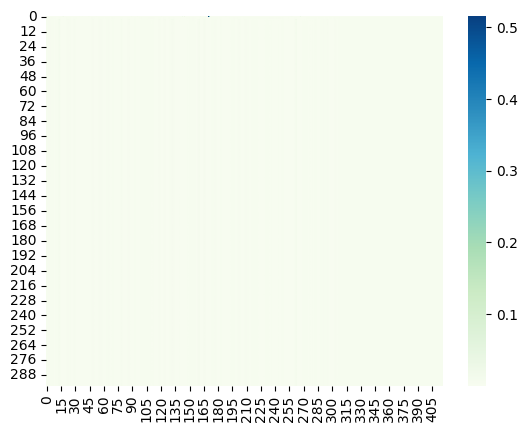

Loss: 2.9791498194919543
Dist: 579.4363839285714
Perplexity: 19.73700572667497

Epoch: 2/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  SHS  EE                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                


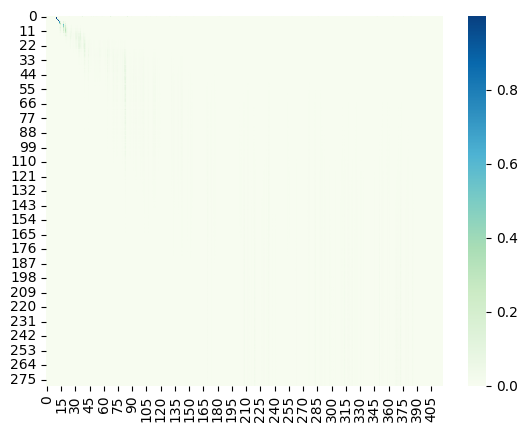

Loss: 2.956655211395092
Dist: 383.90252976190476
Perplexity: 19.23505049287603

Epoch: 3/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THSTTRRNN                O   NNN N                                                                                                                           


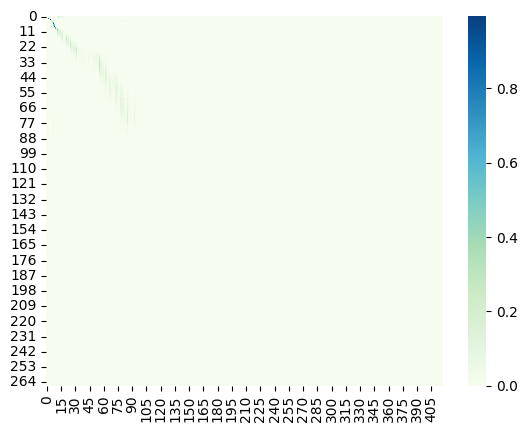

Loss: 2.8536442912026736
Dist: 147.6733630952381
Perplexity: 17.362685621454474

Epoch: 4/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THSSERNN          B B  L    NNNN                                                                                          


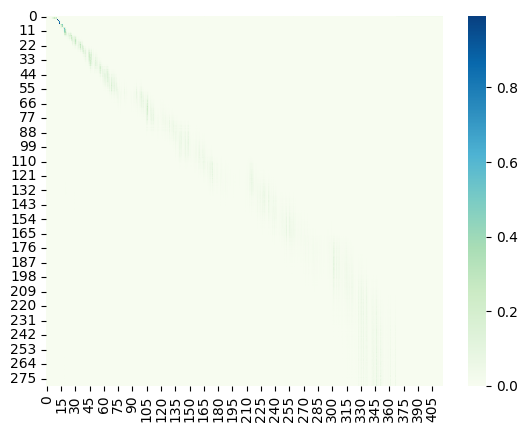

Loss: 2.7646115008364904
Dist: 100.10714285714286
Perplexity: 15.877101872476299

Epoch: 5/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  TO SRINN        AAB     O   NNN                                                                                                                                               


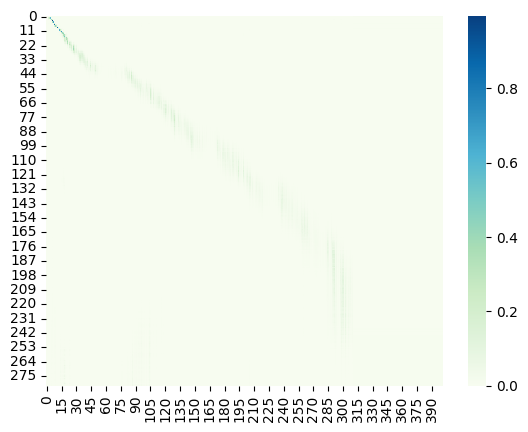

Loss: 2.7098528047625936
Dist: 97.40364583333333
Perplexity: 15.03190420129326

Epoch: 6/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  TUSTTINN         A B  O O  N                                                                                EEEEEE


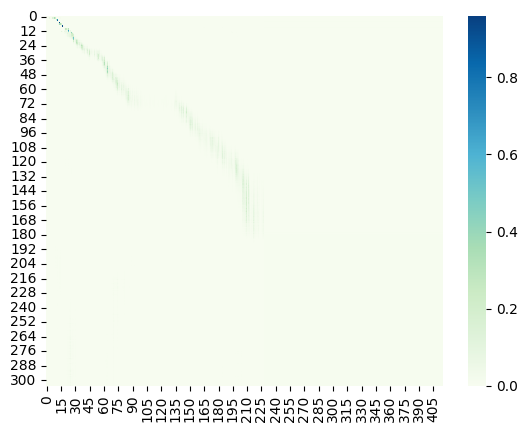

Loss: 2.6705320476146226
Dist: 93.00409226190476
Perplexity: 14.454159912366546

Epoch: 7/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE TTRIN       A AAE L  O     N   AA A                                   O                                  EEEEEEEEEEEEE


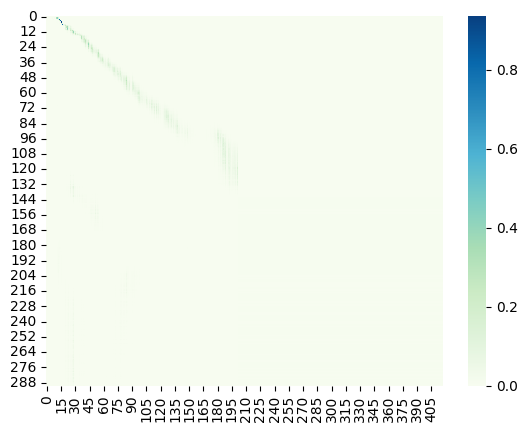

Loss: 2.638291286618522
Dist: 87.44977678571429
Perplexity: 13.997373055875972

Epoch: 8/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THSTTRNN  THA  ANAABE  OOO  NNN   AANN T                                P  T EEEEE                               EE


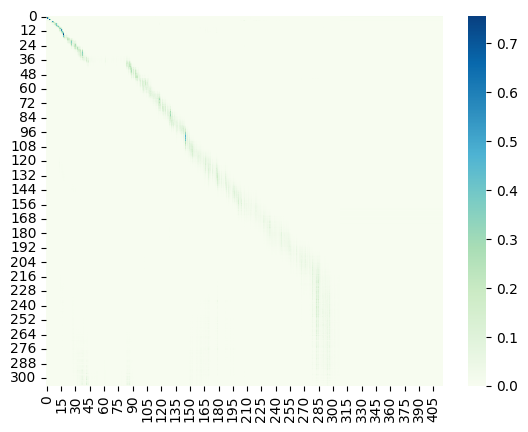

Loss: 2.6238381616185222
Dist: 90.42410714285714
Perplexity: 13.801286875264028

Epoch: 9/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THSTTRINN         AABE            AAT                                       PO   EEEEEE                            D EEE


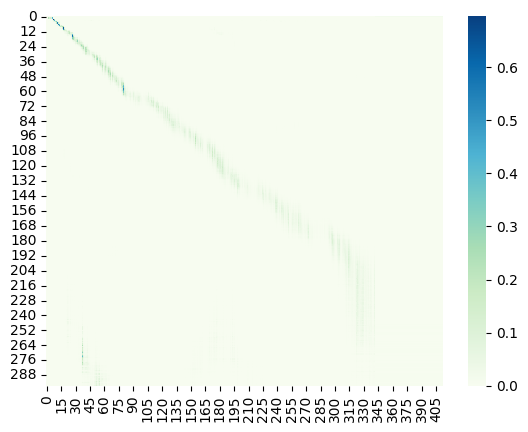

Loss: 2.603006484535303
Dist: 87.87686011904762
Perplexity: 13.51930092800869

Epoch: 10/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THS TIINT          E   OO   N     A A                                    E E                               EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE                                     


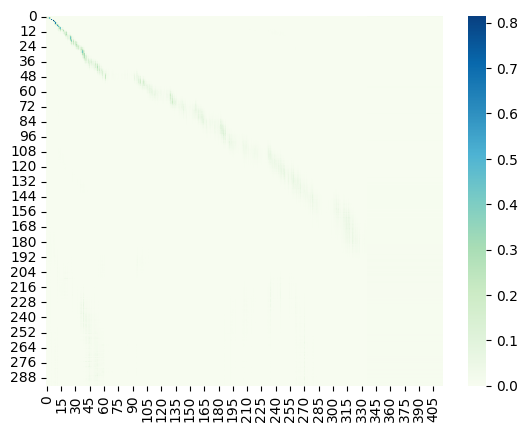

Loss: 2.586490638604325
Dist: 96.59933035714286
Perplexity: 13.298779511183835

Epoch: 11/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE TTRNT  HH     AABE  OO   N    ATTAT                                            E                               EEEE


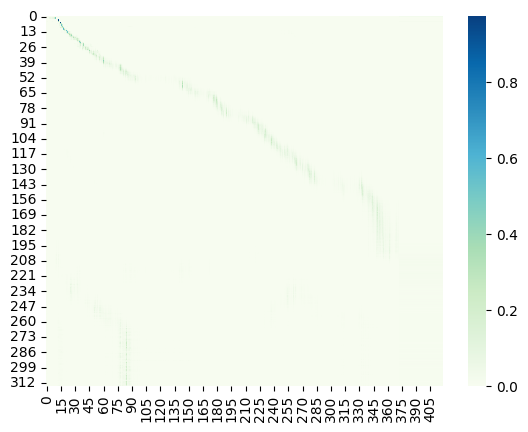

Loss: 2.579362052210261
Dist: 80.13690476190476
Perplexity: 13.21028998085622

Epoch: 12/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE TRINN         AA    OO         AN                                      T EEEEE                        NN NNND  


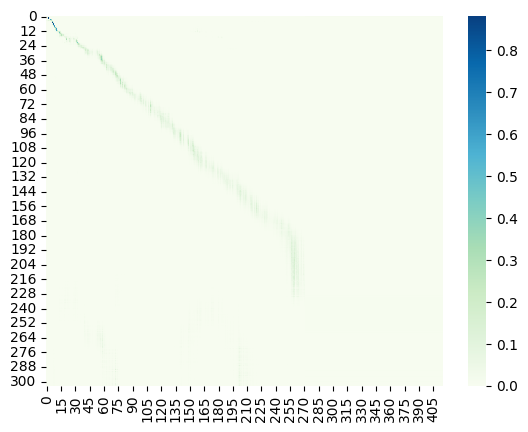

Loss: 2.5573836246233306
Dist: 77.86458333333333
Perplexity: 12.916009613637174

Epoch: 13/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THETTIINT        EEEB  OOOO N N   AAT                                    POTEEEEEEEEEE    O O                  EEEEEE


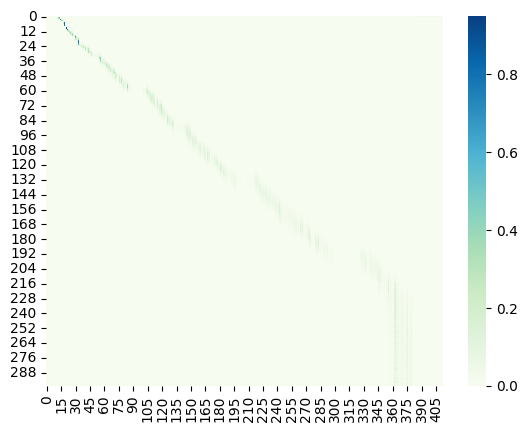

Loss: 2.553691797042161
Dist: 75.51674107142857
Perplexity: 12.873752077509847

Epoch: 14/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE TTIIN            EEE  OO   N      ARN                                  OO T EEEEEEEEEEE    O                   HEE


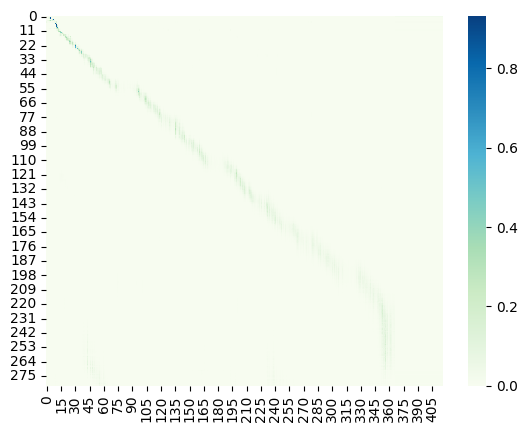

Loss: 2.5307213627890253
Dist: 74.33147321428571
Perplexity: 12.576473823290193

Epoch: 15/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STINN          EEE   OO   N    AAAN                                              EEEEEEE                                  EEEEEE


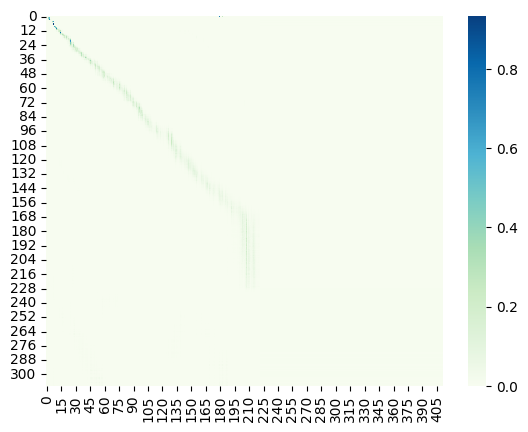

Loss: 2.5315752313378153
Dist: 86.05803571428571
Perplexity: 12.595449751950381

Epoch: 16/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STINNE      N  AAE  OOO   N     ARAN                                   OOTTEEEEEEEEE                       NNNDHEEEE


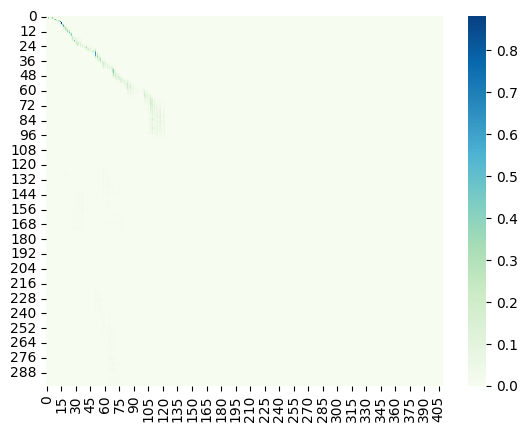

Loss: 2.5099213139394694
Dist: 79.17261904761905
Perplexity: 12.318172544843694

Epoch: 17/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRNNIDD      EBEE   OO         AANN                                 POPOTEEEEEEE           T     H       D  HEEEE


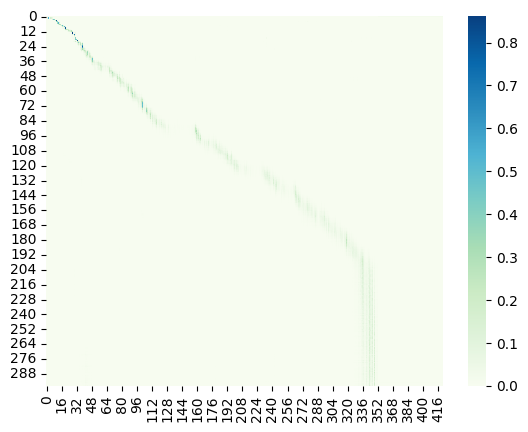

Loss: 2.501627723822433
Dist: 72.32105654761905
Perplexity: 12.219793613305253

Epoch: 18/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE TTRIN          EEE   OO          AA                                        EEEEEEEE                    NN DDEEEEEE


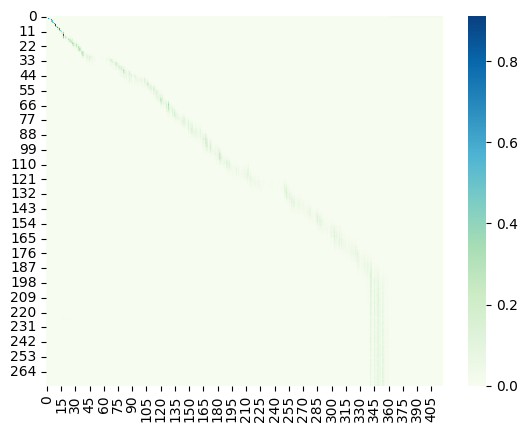

Loss: 2.5001265375801687
Dist: 76.39248511904762
Perplexity: 12.207108120436079

Epoch: 19/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINH HAD  NNABBEL OOOO NN    AARANN      HH       Y  T              PPETTEEEEEEEEE                   NNN DDEEEEEEE


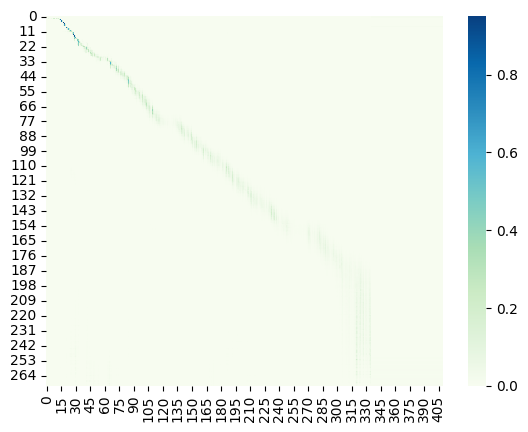

Loss: 2.509659987353207
Dist: 74.00818452380952
Perplexity: 12.337384101781952

Epoch: 20/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE TTINN               OO          AAAN                                  OOT  EEEEE                          EEEEEEEE


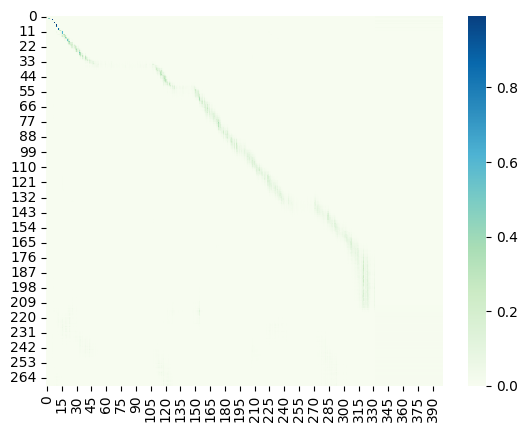

Loss: 2.4847532079460914
Dist: 79.30877976190476
Perplexity: 12.027617484532046

Epoch: 21/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STINNE        AAAE  OOO         AANN   OO  H                          OOOOTTEEEEEEEE   OOOO      HHE  AAN   EEEE


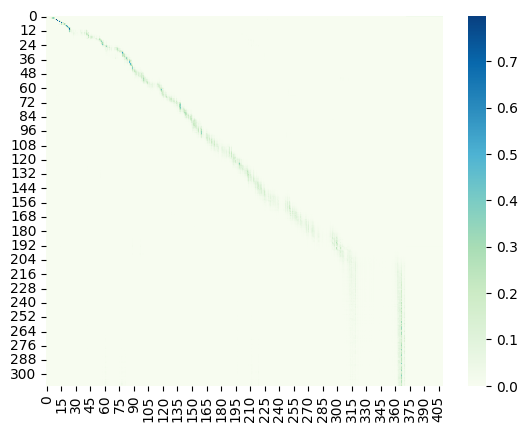

Loss: 2.464797624309411
Dist: 69.65401785714286
Perplexity: 11.778863521104448

Epoch: 22/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STINN  H       AAAE   OO   N     AAR                                     OOTTEEEEEEEEEE                           EEEEE


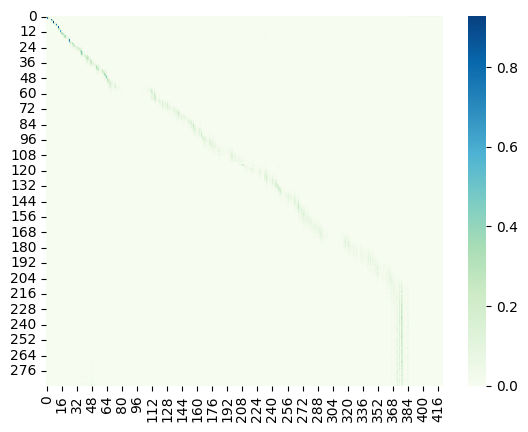

Loss: 2.447846977898244
Dist: 73.62611607142857
Perplexity: 11.581467877077253

Epoch: 23/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STINNE  HHE  AAAAL  OOEE  NN    AANN               D                  POOTTEE       OOOOOO                    EEEE


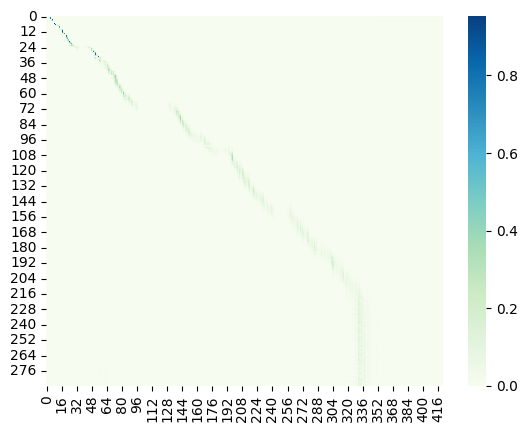

Loss: 2.4264638911472276
Dist: 73.19642857142857
Perplexity: 11.329268802685684

Epoch: 24/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STINN         AABEE  OO        AAANN     HH                           OOTTEE            OOOOONN  THEE         EE


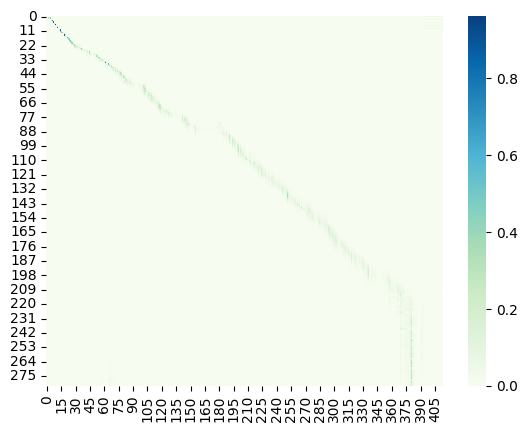

Loss: 2.4185123272156446
Dist: 68.32291666666667
Perplexity: 11.247460736049694

Epoch: 25/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  TO STINN          AALEE  OO  NN    AANN   O          DD                     OEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE


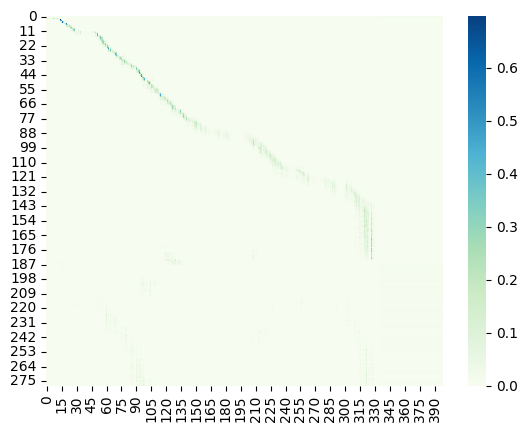

Loss: 2.3866155742259507
Dist: 69.62760416666667
Perplexity: 10.893987670641266

Epoch: 26/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRNNE              OO          AANN   O                   II  AN         TTHE  EE      OOO        HHEE          HEES


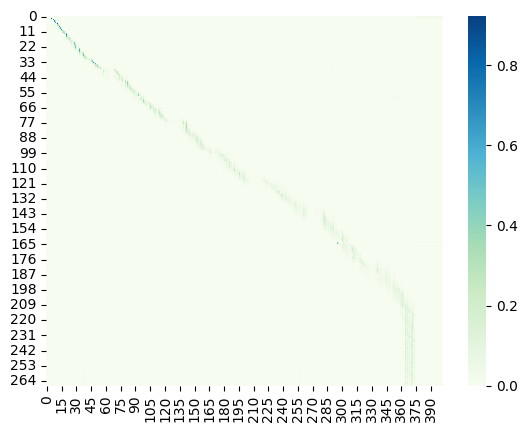

Loss: 2.364436733588744
Dist: 71.04427083333333
Perplexity: 10.657308807801664

Epoch: 27/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRNNT  HH   N  AAL  OO   NN    RRNN   O  HH      B                   OOOOOEE EEEEOOO  OO OONNTTHE HHENNDD HHEEE


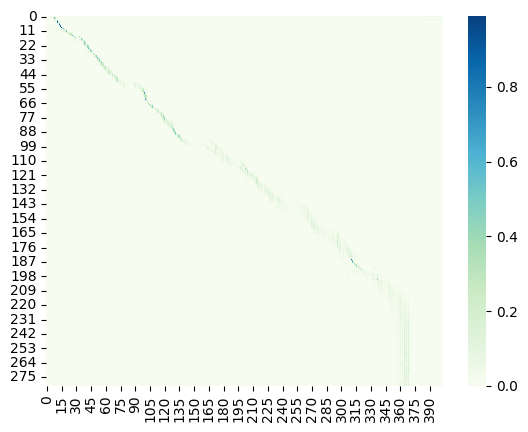

Loss: 2.358300512292412
Dist: 65.75595238095238
Perplexity: 10.602166006538305

Epoch: 28/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRNNE  HH  NN AABEE OOEE  N    AAAA   OO HH            TT  F        MMORREE  EECECCC  OO  OOON  THHE HEED  ADD


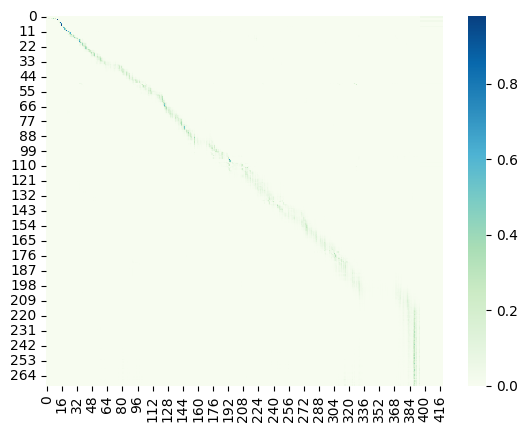

Loss: 2.332457326503282
Dist: 66.29315476190476
Perplexity: 10.326366036661556

Epoch: 29/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRNNTTHHE  NN AAEE  OO         AANN   OO                                OOOTTEEEEEEEEEEE  OOOO       HHENND  EEEEE


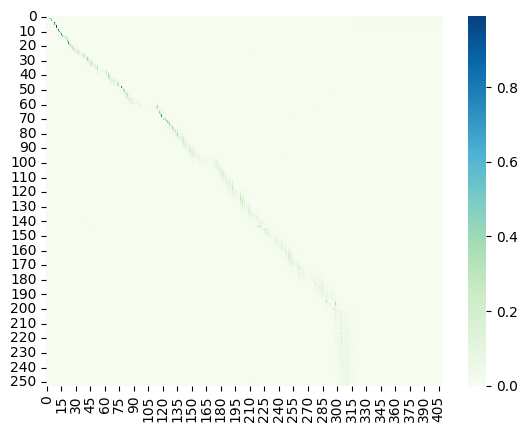

Loss: 2.313446732317464
Dist: 67.53087797619048
Perplexity: 10.125868072938383

Epoch: 30/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINTT          BEE  O                                   TT                  TTTEEEEEEEEEE    OO       HHE HHH  DD  HHELL


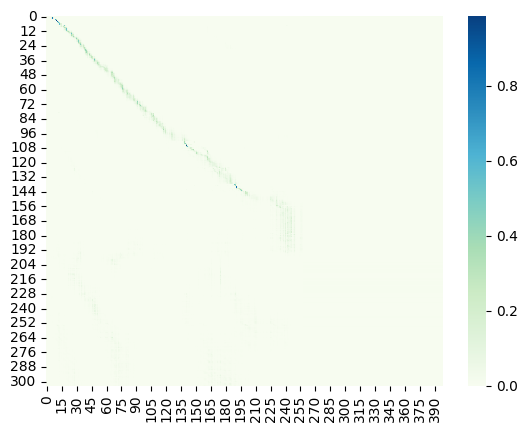

Loss: 2.308778257048532
Dist: 77.22284226190476
Perplexity: 10.087384776854783

Epoch: 31/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRING THH           SOO          AAN                                         EEEEEEEEE                              EE  SSEESS


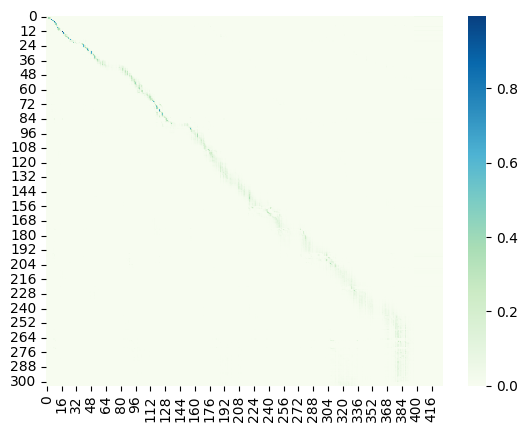

Loss: 2.3059058146530322
Dist: 89.08110119047619
Perplexity: 10.058487401383646

Epoch: 32/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  TO STRNNT THH   N  A                AAN                                 P  TTEEEEEEEEEE    OO                   EESS


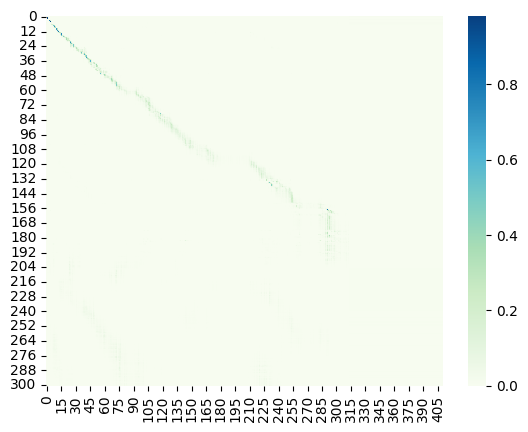

Loss: 2.292488351564729
Dist: 84.73846726190476
Perplexity: 9.921192972847585

Epoch: 33/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINT  HH   NAAALL  OONN     AAN                                        EEEEEEEEEE                              SS


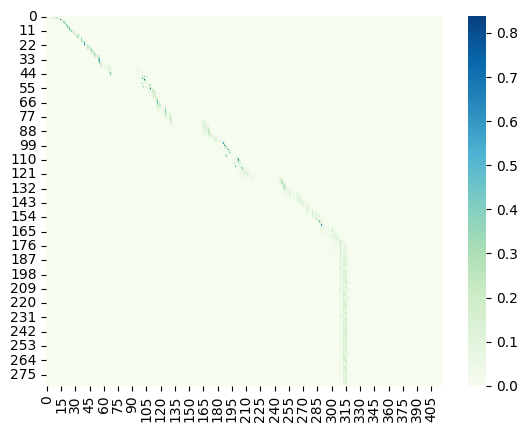

Loss: 2.3030082386531188
Dist: 70.71800595238095
Perplexity: 10.029974836713812

Epoch: 34/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRNNINN     A    SSOO        AANN                                                  OO    TT                


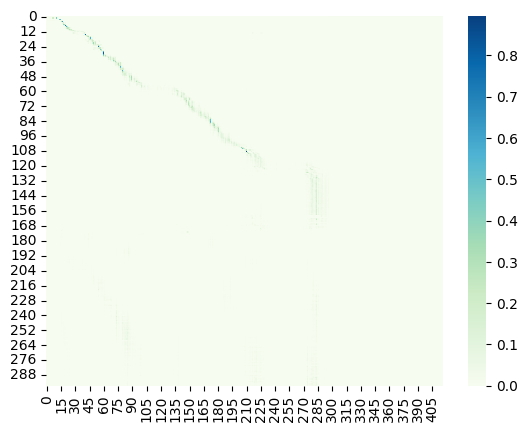

Loss: 2.3029641221078596
Dist: 79.11421130952381
Perplexity: 10.03055400419771

Epoch: 35/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRNNT      NAAALL  SO  NN    AANNC  TO HHEE                              EE EEEEEE           TT EE HAD  AAN  EEE


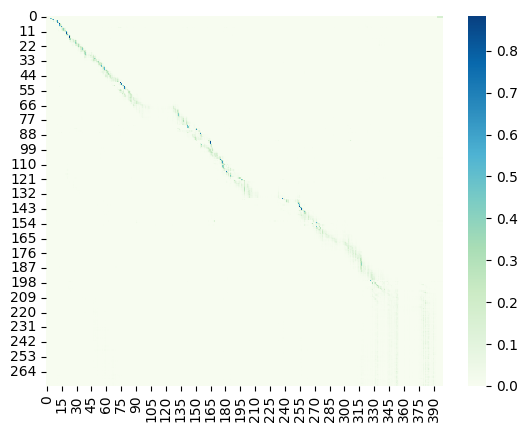

Loss: 2.30796677771579
Dist: 72.19159226190476
Perplexity: 10.084787675236049

Epoch: 36/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINNEE      BBEE  SOO       AANN  TO                              OOOTTEE  EEEEE                    NND HELL


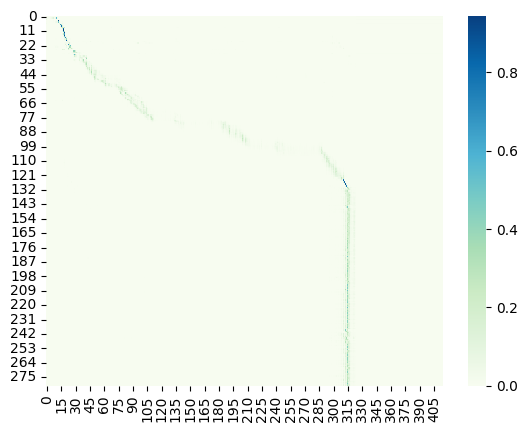

Loss: 2.302409014541112
Dist: 71.6733630952381
Perplexity: 10.025070631905887

Epoch: 37/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRNNN   DD ANAALL  SOO  NN   TT  T     HH             TT             PPOOTTEEEEEEEEEEEEEE  OO  NN      HHE  N  AAN  


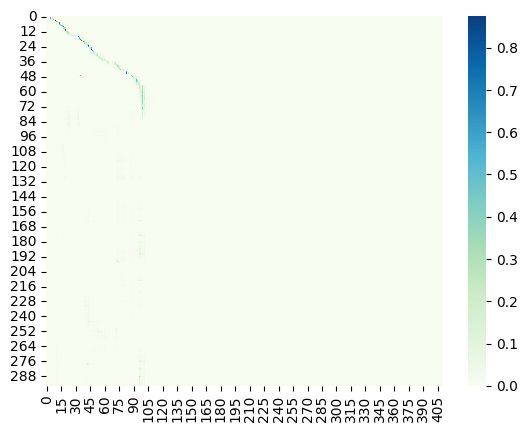

Loss: 2.2133622458811555
Dist: 74.66629464285714
Perplexity: 9.167647197809112

Epoch: 38/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRNNN        AAALL  OO       TTAANN  T   HH                          POORTTEEEEEEEEE     OOO         EE        EEEE


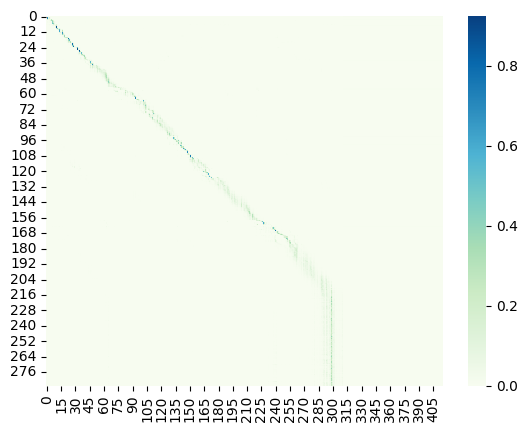

Loss: 2.1817560439699153
Dist: 73.50260416666667
Perplexity: 8.881818649206268

Epoch: 39/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINNEE       AALL  SOO       TTAANTT   HH              TT  A      PPOOTTEE  EEEEE     OONNC  THE HANDD  NDD HEEL


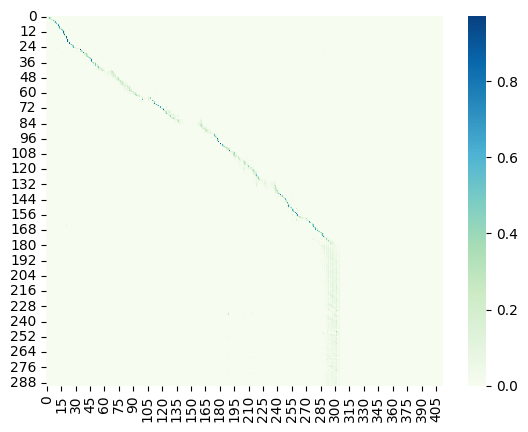

Loss: 2.1739028277022117
Dist: 68.04575892857143
Perplexity: 8.816846036375239

Epoch: 40/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRNNN               OOO       TT                      TT                      EEEE       OO                                                                                                                           


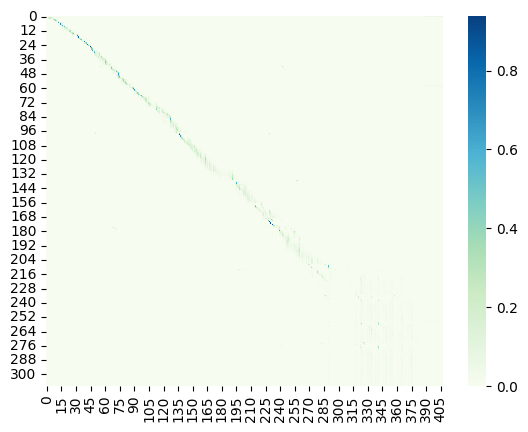

Loss: 2.1571247269598284
Dist: 85.48400297619048
Perplexity: 8.67601526989026

Epoch: 41/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRNNEE     AAALL              AANN                                    OORRTTEE  EEEEEE                                 SS


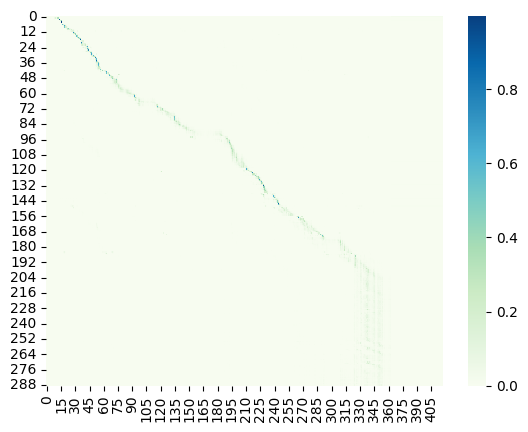

Loss: 2.1354193802629964
Dist: 81.0703125
Perplexity: 8.486051352640215

Epoch: 42/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STINNNEE     AAAAL  O         AAN  TO  HH                          PPOOTTEEEEEEEEE                                SS


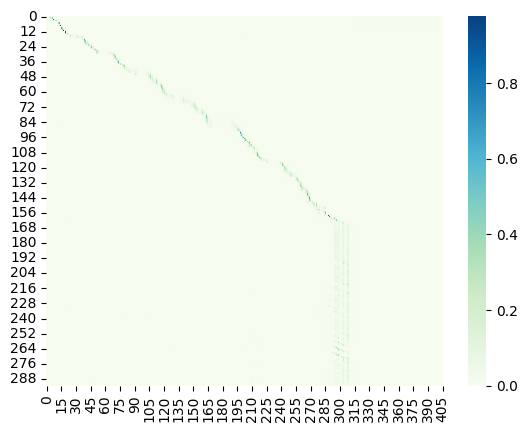

Loss: 2.128934985868047
Dist: 71.34002976190476
Perplexity: 8.431023308400357

Epoch: 43/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINNEE       AAAAL  OO  N      AANN       HH                              TTEE  EEEEEE                                  


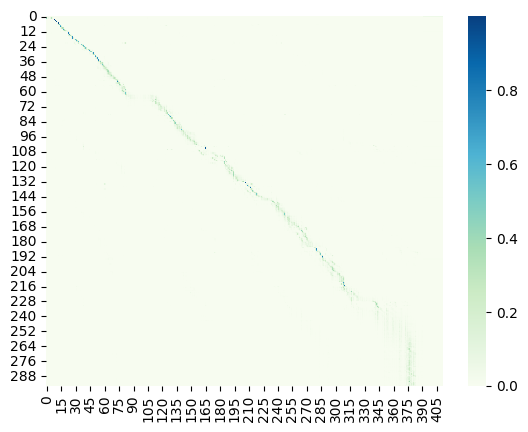

Loss: 2.1277495853016886
Dist: 78.55803571428571
Perplexity: 8.427577018737793

Epoch: 44/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRNNN        AAA  SS  O       RAAN      HHE       DD Y  SS  AN    SSOOP  EEEEEEEEEEEEE                        EE


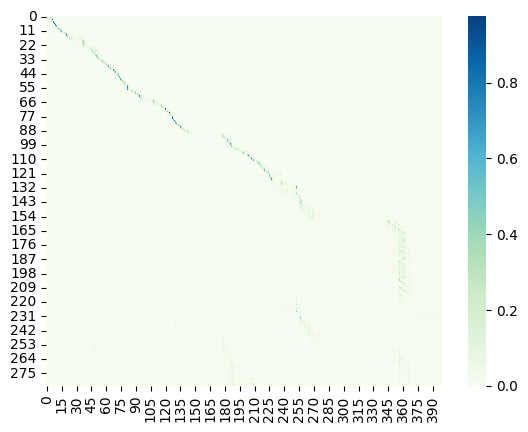

Loss: 2.1074183576562433
Dist: 78.90811011904762
Perplexity: 8.253915507070134

Epoch: 45/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRING  HH     AAAA   OO         AAN       HH                               EE  EEEEEE                                   


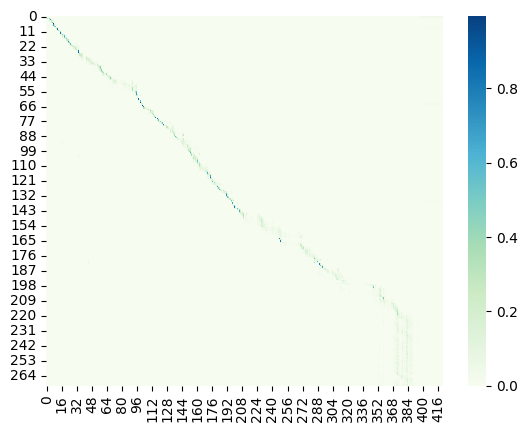

Loss: 2.123852873384283
Dist: 90.58482142857143
Perplexity: 8.401960890480641

Epoch: 46/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRING  TH     AABE   SOON  I                               II               EE  EEEEEEE                                    EE SS


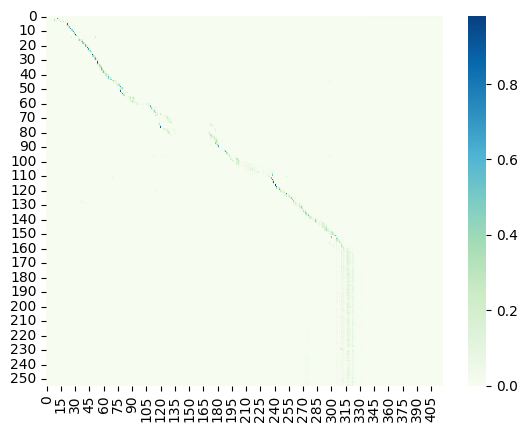

Loss: 2.1123108566477056
Dist: 91.36755952380952
Perplexity: 8.302546545092978

Epoch: 47/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  TO STRING  THAT AN AALL  SOO         TTRANN                                                               HHE   AAND HEEEE


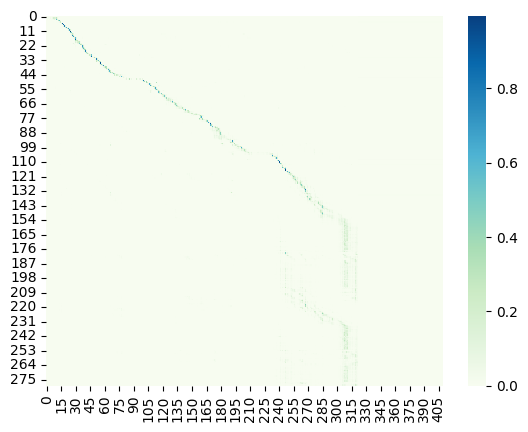

Loss: 2.1382376748524354
Dist: 95.35081845238095
Perplexity: 8.52683475794417

Epoch: 48/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINN                OO           AANN                                        EE EEEEEEEE                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         


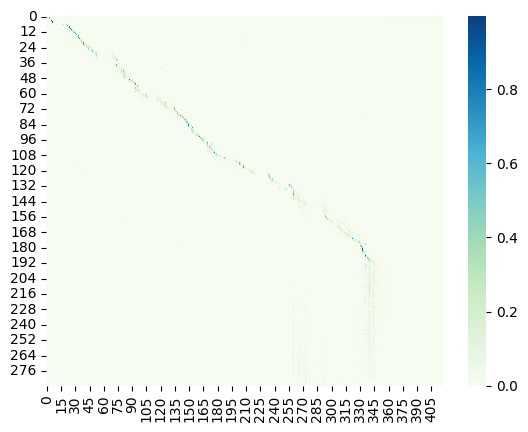

Loss: 2.1058103606941994
Dist: 94.38355654761905
Perplexity: 8.249960147129016

Epoch: 49/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRING         EEEE   OOOONN      AANTT                                           EEEEEE              TTHE EE  AA                                                                                          


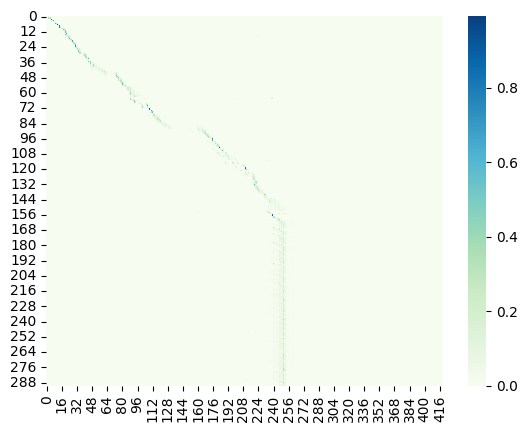

Loss: 2.0666572455609784
Dist: 87.07440476190476
Perplexity: 7.924255723631783

Epoch: 50/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRING  HHA     EEA  SOOO ONN       TT AAN  T                                    TT    EEEE                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        


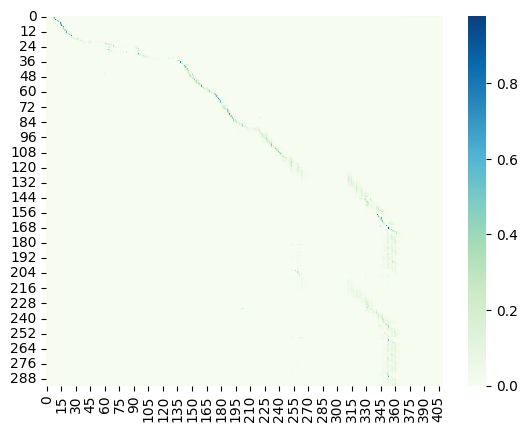

Loss: 2.0826842458060617
Dist: 124.8110119047619
Perplexity: 8.057697584387961

Epoch: 51/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  TH STRINN  THAT      EE  SOO           RRANTT                                      TTEE  EEEE                                                                                                                   


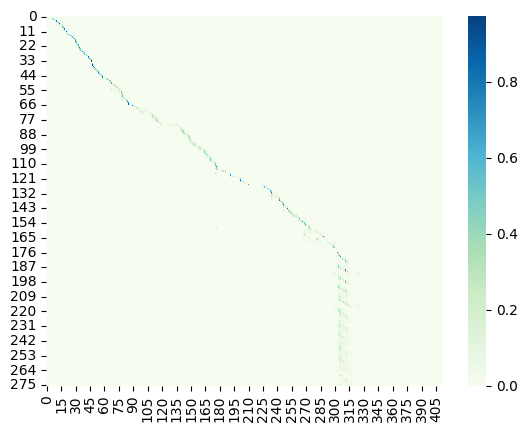

Loss: 2.1001841526352956
Dist: 95.81212797619048
Perplexity: 8.208905255392697

Epoch: 52/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINT  THAA          SSOOO          TTRAAN                                                EEEE                                SS


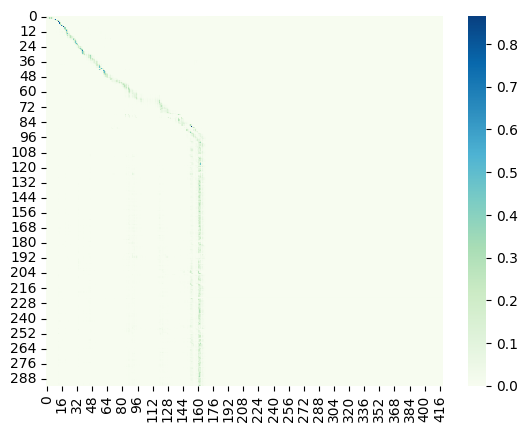

Loss: 2.0959059956368438
Dist: 161.34747023809524
Perplexity: 8.163942524556363

Epoch: 53/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  TO STRNNT  HHA  AN AALLE  OO  NN        AAAN  T                                 OO    EE  EEEEEEEEEEE                          SS


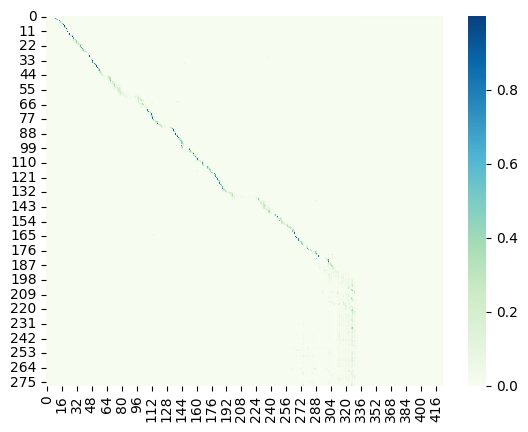

Loss: 2.075754734103599
Dist: 86.54873511904762
Perplexity: 7.998806082264761

Epoch: 54/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  TO STINNT  HH                           AANN                                                                                                                          


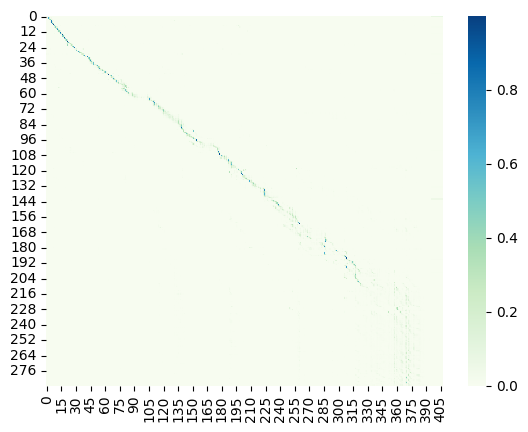

Loss: 2.006065344006828
Dist: 99.84821428571429
Perplexity: 7.4551232145073705

Epoch: 55/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  TO STRNNT  HHH      AAAAA                AANN                                              EE                                                                                   


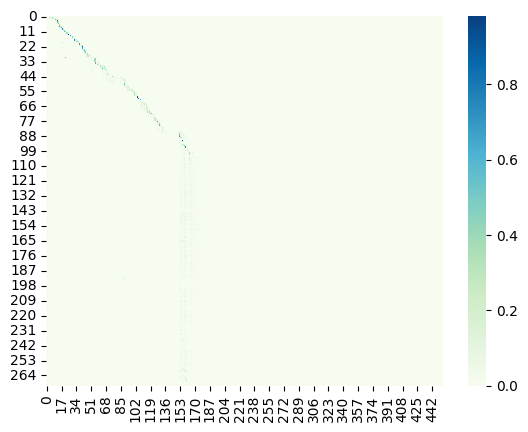

Loss: 1.9743249448497644
Dist: 93.25818452380952
Perplexity: 7.227878499834725

Epoch: 56/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  TO STRNNT  HH       AALLLLL  NN      TTRRANNN                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          


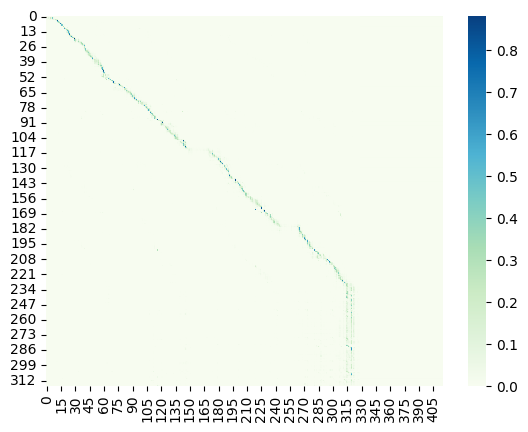

Loss: 1.9313176854272907
Dist: 134.86681547619048
Perplexity: 6.922257030144166

Epoch: 57/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE TTTT  TT                                                                                                              SS


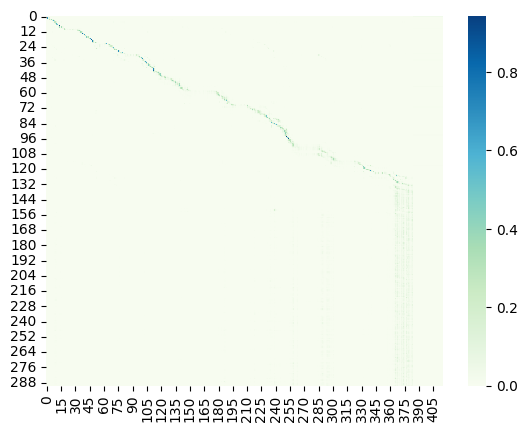

Loss: 1.9077129503314414
Dist: 109.23735119047619
Perplexity: 6.757875149973323

Epoch: 58/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINT   HH      EE                                                                                                       EE


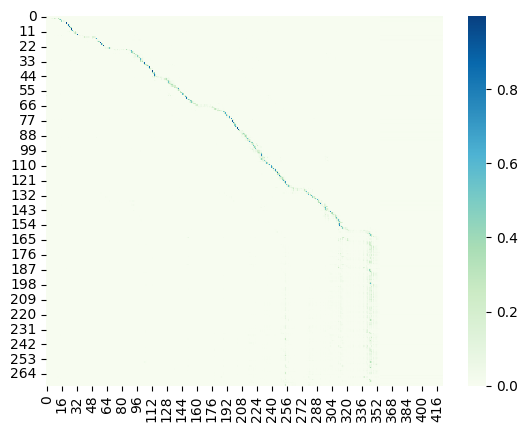

Loss: 1.8779904877201894
Dist: 89.91034226190476
Perplexity: 6.562782077574997

Epoch: 59/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE TTTTT                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              


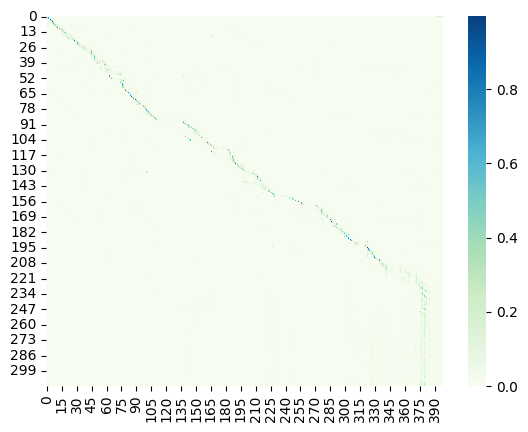

Loss: 1.8590666819154547
Dist: 117.50372023809524
Perplexity: 6.439101116309005

Epoch: 60/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRRNN  THHA     EE                                                                                                         SS


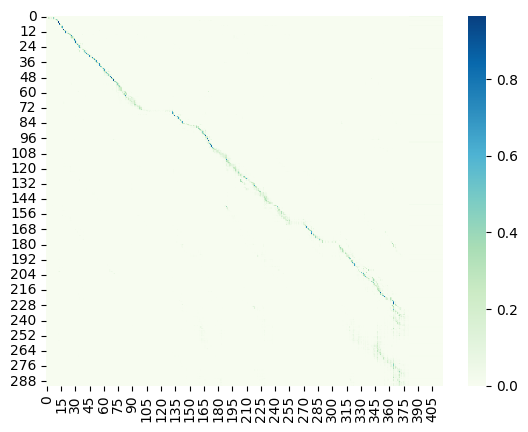

Loss: 1.839969778060913
Dist: 139.66778273809524
Perplexity: 6.3201401356900675

Epoch: 61/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE TTRRINN  TT                           AANN                 DDD                                                             EESS


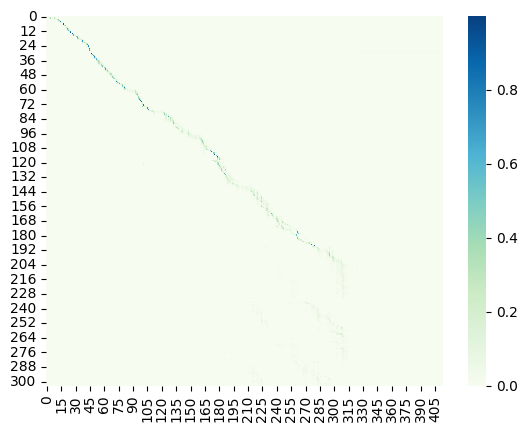

Loss: 1.8341269782419956
Dist: 112.1328125
Perplexity: 6.282404953174376

Epoch: 62/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINN  TTH            OO           RRAAN                  DD                       EEEEEEEE  TT     TTHE   EE            EESS


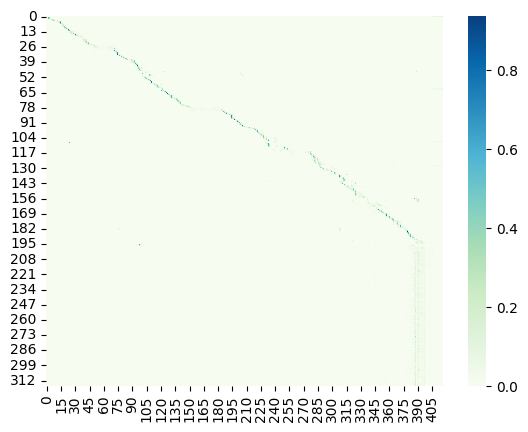

Loss: 1.8095788575290295
Dist: 126.35119047619048
Perplexity: 6.126714981807751

Epoch: 63/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINN   HH             OO            AAN  TOO                                         EEEEEE                                     


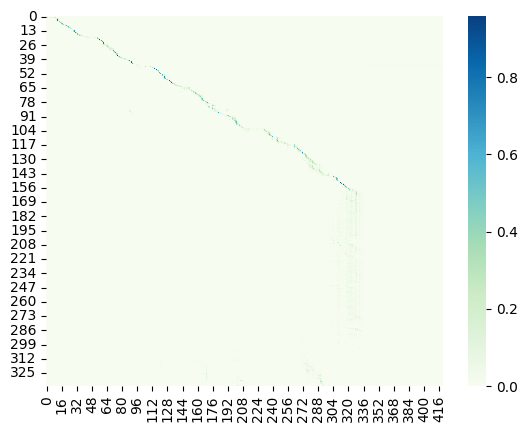

Loss: 1.7901842044980338
Dist: 91.30840773809524
Perplexity: 6.010396241605951

Epoch: 64/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINN  THH      AAA  SO NN  NN    AANN               DD                  OORREE  E  EE                                SS


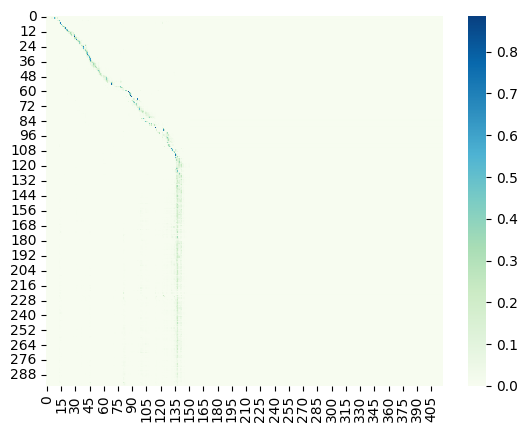

Loss: 1.783067110683141
Dist: 102.10342261904762
Perplexity: 5.968878066673708

Epoch: 65/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRING  TT        LLEE    NN        AAN  T                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         


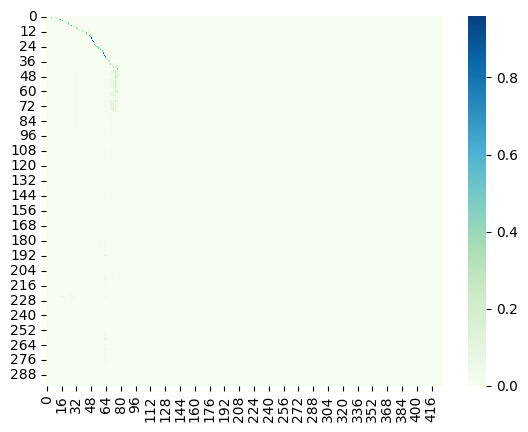

Loss: 1.7707203744502549
Dist: 232.18861607142858
Perplexity: 5.8981956321201965

Epoch: 66/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRING  HHA              NN  NN      AAN  TT                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       


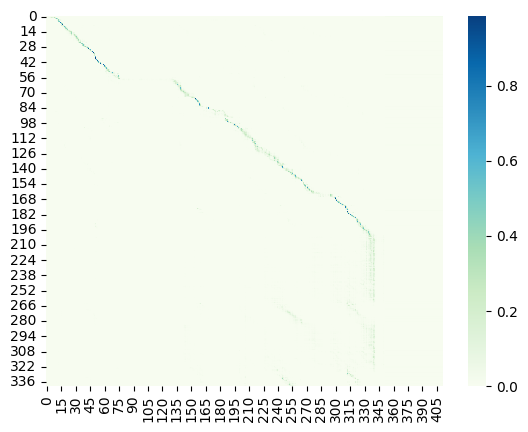

Loss: 1.73421324853147
Dist: 136.49293154761904
Perplexity: 5.681426212225068

Epoch: 67/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRING  TTH                         AANN                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           


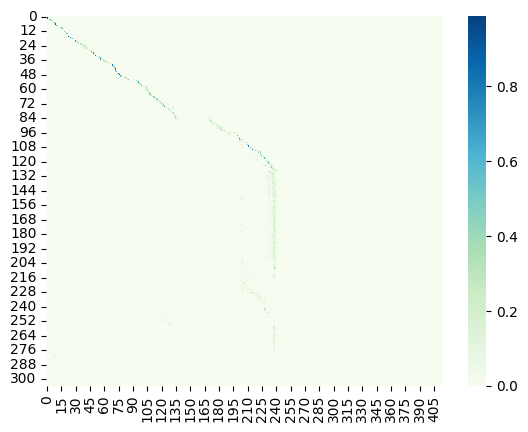

Loss: 1.7254125726356935
Dist: 161.40066964285714
Perplexity: 5.637025729190098

Epoch: 68/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINN  TTH              OON                                                         EE    TT                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      


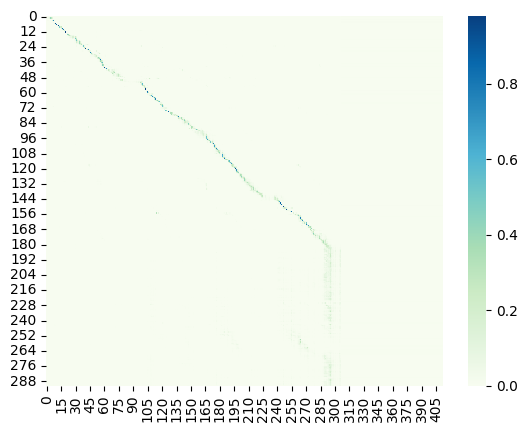

Loss: 1.7027848591965236
Dist: 148.8311011904762
Perplexity: 5.508635646305727

Epoch: 69/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINN  THH     AAAALL  SS  N      TTTTTTTT                                     EE  EE                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             


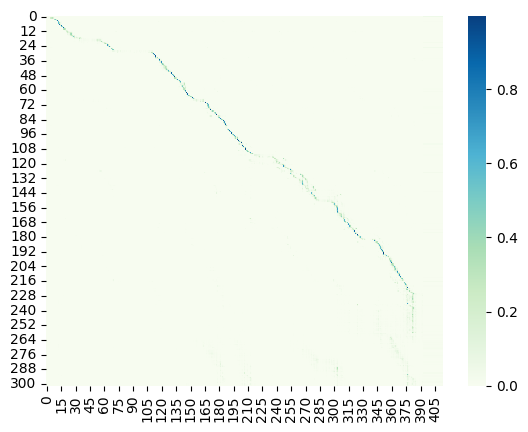

Loss: 1.697053922963946
Dist: 117.47209821428571
Perplexity: 5.473113346099853

Epoch: 70/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINN  TTHAA           OON  IN    TT                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              


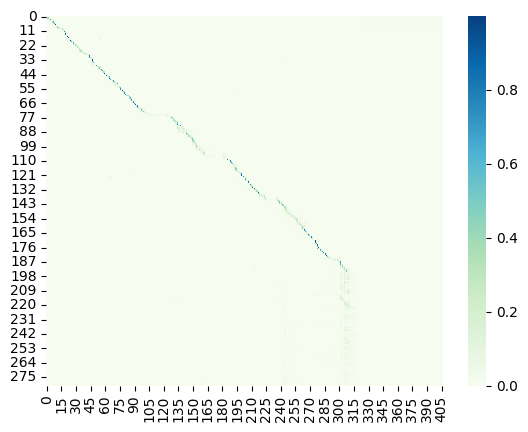

Loss: 1.6784088204415997
Dist: 177.9795386904762
Perplexity: 5.3755978787882945

Epoch: 71/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRING  HHHHH           OON  NN    TT                                            EEEEEEEE                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          


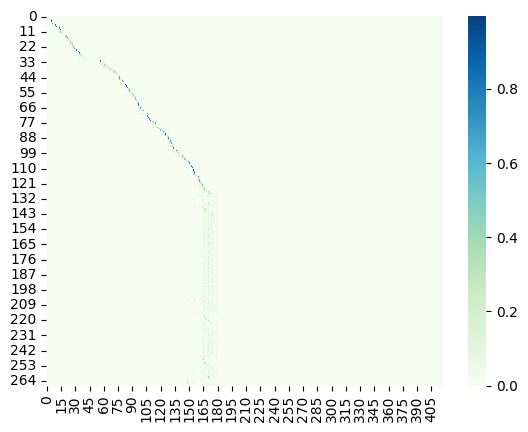

Loss: 1.6566516402062406
Dist: 144.51971726190476
Perplexity: 5.258022438006455

Epoch: 72/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRING TTHHH       AALL  OON         TT                                      OORREE  EEEEEEEEEEEE                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  


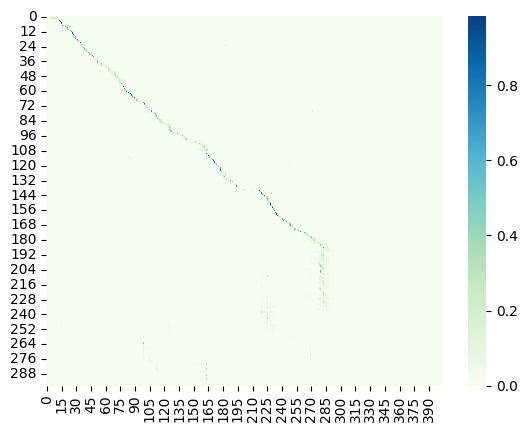

Loss: 1.6519536106773975
Dist: 149.74032738095238
Perplexity: 5.232381428493543

Epoch: 73/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRING  THHHH    AAA    OO   N      TT                                          EE  EEE  TT                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        


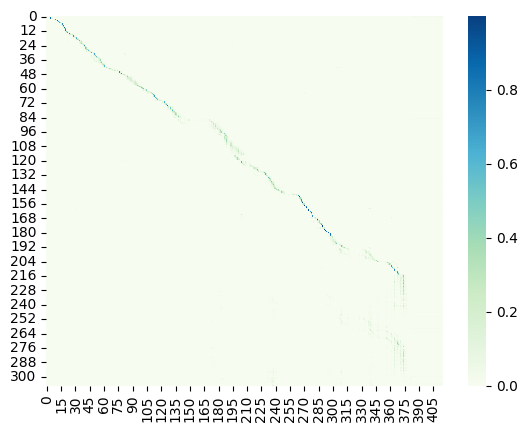

Loss: 1.6243093779917512
Dist: 138.98363095238096
Perplexity: 5.091647328151746

Epoch: 74/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRING  THHHHH  AABEE  SOOO         TT                                    OOOO  EEEEEEE                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            


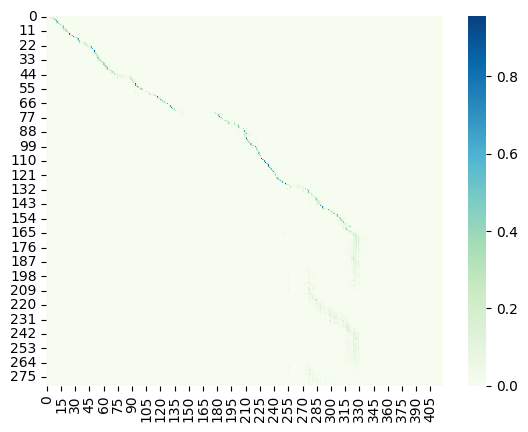

Loss: 1.6136580378821728
Dist: 130.33221726190476
Perplexity: 5.038534917724267

Epoch: 75/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINN   TT                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        


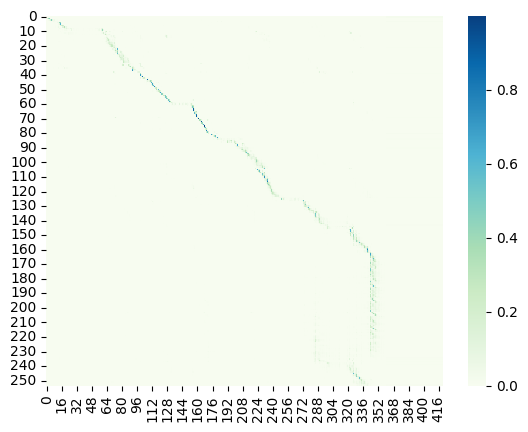

Loss: 1.595808055695523
Dist: 179.14880952380952
Perplexity: 4.946648224819912

Epoch: 76/150


Train:   0%|          | 0/445 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [29]:
best_lev_dist = float("inf")

# Train the model
for epoch in range(0, config['epochs']):
    
    print("\nEpoch: {}/{}".format(epoch+1, config['epochs']))

    # Call train and validate, get attention weights from training
    running_loss, running_perplexity, attention_plot = train(
        model,
        train_loader,
        criterion,
        optimizer,
        tf_scheduler)

    valid_dist = validate(model, dev_loader)    

    # Plot Attention for a single item in the batch
    plot_attention(attention_plot[0].cpu().detach().numpy())
    print('Loss:',running_loss)
    print('Dist:',valid_dist)
    print('Perplexity:',running_perplexity)

    wandb.log({
        'train_loss': running_loss,  
        'valid_dist': valid_dist, 
        'train_perplexity': running_perplexity, 
        'lr'        : optimizer.param_groups[0]['lr'],
        'tf_lr': tf_scheduler.ratio
    })

    # Scheduler Step & Teacher Forcing Schedule Step
    tf_scheduler.step()
    scheduler.step(running_loss)

    if valid_dist <= best_lev_dist:
        best_lev_dist = valid_dist
        torch.save({'state_dict': model.state_dict()}, 'best.pth')

In [ ]:
run.finish()